# Import Modules

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from numpy import asarray
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report

# %tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import * 
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import backend as K
from tensorflow.keras import losses
from tensorflow.keras.utils import plot_model
# from tensorflow import keras

# import keras
# from keras.preprocessing.text import Tokenizer
# from keras.layers import *
# from keras.preprocessing.sequence import pad_sequences
# from keras import callbacks

def VisRes(res):
    plt.plot(list(res.history.values())[0],'b',label='Train-Loss')
    plt.plot(list(res.history.values())[1],'orange',label='Train-Accuracy')
    plt.plot(list(res.history.values())[2],'g',label='Valid-Loss')
    plt.plot(list(res.history.values())[3],'y',label='Valid-Accuracy')
    plt.legend(loc='best', shadow=True)

np.random.seed(1)
from tensorflow.random import set_seed
set_seed(2)

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 177854895027714019
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8576508177539915429
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3526787237439022967
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14640891840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11653773485629762107
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


# Import Data 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/My Drive/PY/SemEval2021

/content/drive/My Drive/PY/SemEval2021


# Prepare Data

In [4]:
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords,wordnet
# from nltk.stem import PorterStemmer,WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
stopwordEn = stopwords.words('english')
def lemmaWord(word):
    lemma = wordnet.morphy(word) 
    # lemmar = WordNetLemmatizer()
    # lemma = lemmar.lemmatize(word) 
    if lemma is not None:
        return lemma
    else:
        return word
def processText(text,lemma=False, gram=1, rmStop=True): # default remove stop words
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b|@\w+|#', '', text, flags=re.MULTILINE) #delete URL, #hashtag# , and @xxx
    tokens = word_tokenize(text)
    whitelist = ["n't", "not", "no"]
    new_tokens = []
    stoplist = stopwordEn if rmStop else []
    for i in tokens:
      i = i.lower()
      if i not in ['.',',',';'] and (i not in stoplist or i in whitelist):  #i.isalpha() and (...)
        if lemma: i = lemmaWord(i)
        new_tokens.append(i)
    del tokens
    # tokens = [lemmaWord(i.lower()) if lemma else i.lower() for i in tokens if (i.lower() not in stoplist or i.lower() in whitelist) and i.isalpha()]
    if gram<=1:
        return new_tokens
    else:
        return [' '.join(i) for i in nltk.ngrams(new_tokens, gram)]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [5]:
data = pd.read_csv("train.csv")
data.loc[:,'tokens'] = [processText(t, rmStop=True) for t in data.text]
data.loc[:,'token_len'] = [len(t) for t in data.tokens]
data['humor_rating'] = data['humor_rating'].fillna(0)
data.head()

,id,text,is_humor,humor_rating,humor_controversy,offense_rating,tokens,token_len
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.2,"[tennessee, :, 're, best, state, nobody, even,...",17
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.1,"[man, inserted, advertisement, classifieds, ``...",24
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.4,"[many, men, take, open, beer, ?, none, open, t...",11
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.0,"[told, mom, hit, 1200, twitter, followers, poi...",17
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.1,"[roses, dead, love, fake, weddings, basically,...",8


In [6]:
with open('train_tokens.pickle', 'rb') as handle:
    data = pickle.load(handle)

# Tokenization


In [8]:
# Word Embedding
np.random.seed(1)
set_seed(2)
t = Tokenizer()
t.fit_on_texts([' '.join(i) for i in data['tokens']])

def encodeText(orig_tokens,max_len=0):  
  vocab_size = len(t.word_index) + 1
  encoded_train = t.texts_to_sequences([' '.join(i) for i in orig_tokens])
  max_length = max(list(map(lambda x: len(x), encoded_train))) if max_len==0 else max_len
  padded_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')
  return padded_train, vocab_size, max_length

X, vocab_size, max_length = encodeText(data['tokens'])
Y = to_categorical(data['is_humor'])
X.shape, vocab_size, max_length #((8000, 68), 14766, 68)

((8000, 68), 14766, 68)

## Pre-Trained GloVe Embedding

In [7]:
# load the whole embedding into memory
EMB_DIM = 50
embeddings_dict = {}
with open(F"./GLOVE/glove.twitter.27B.{EMB_DIM}d.txt", 'rb') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        if len(vector)==EMB_DIM:
            embeddings_dict[word] = vector
print('Loaded %s word vectors.' % len(embeddings_dict))

Loaded 1193514 word vectors.


In [9]:
emb_matrix = np.zeros((vocab_size, EMB_DIM))

for w, i in t.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < vocab_size:
        vect = embeddings_dict.get(bytes(w, 'utf-8'))
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break
emb_matrix.shape

(14766, 50)

# Modelling

## Loss test

In [ ]:
y_true = [[1],[1],[1]]
y_pred = [[0.5],[1],[0]]
loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
loss

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.69314694, -0.        , 15.424949  ], dtype=float32)>

In [ ]:
def custom_loss(y_true, y_pred):
            
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return loss

### Example 1
通过concat target and weight,在loss中引入weight

https://stackoverflow.com/questions/57704771/inputs-to-eager-execution-function-cannot-be-keras-symbolic-tensors


In [ ]:
data_y.shape, data_yw.shape

((5, 1), (5, 2))

In [ ]:
from tensorflow.keras import losses
# data_x = 2 * np.ones((7, 11, 15, 1), dtype=float)
# data_y = 5 * np.ones((7, 9, 13, 1), dtype=float)
data_x = np.array([[1,2],[2,1],[3,4],[3,2]])
data_y = np.array([[1.0],[0.0],[1.0],[0.0]])
x = Input(data_x.shape[1:])
y = Dense(1, activation='sigmoid')(x)
# y = Conv2D(5, kernel_size=3)(x)
model = Model(inputs=x, outputs=y)

def loss(y_true, y_pred): # y_true中夹带了w
    tf.print(y_true, "== data_yw")
    (y_true, w) = tf.split(y_true, num_or_size_splits=2, axis=1) # 把拼接的权重拆分开
    loss = tf.squeeze(w, axis=-1) * losses.mse(y_true, y_pred)
    tf.print(y_true, "== y_ture")
    tf.print(tf.math.reduce_mean(loss), "== batch loss")
    tf.print(w, "== w")
    return loss

model.compile(loss=loss)

data_w =  [[1],[2],[3],[4]] # np.ones((4,1), dtype=float) # 权重 [[1],[2],[3],[4]]
data_yw = np.concatenate((data_y, data_w), axis=-1) # 把相同长度的权重拼接在data_y后面
model.fit(data_x, data_yw)

[[0 2]
 [0 4]
 [1 1]
 [1 3]] == data_yw
[[0]
 [0]
 [1]
 [1]] == y_ture
0.343774378 == batch loss
[[2]
 [4]
 [1]
 [3]] == w
1/1 [==============================] - 0s 2ms/step - loss: 0.3438


In [ ]:
data_x = 2 * np.ones((4, 11, 15, 1), dtype=float)
data_y = 5 * np.ones((4, 9, 13, 1), dtype=float)
x = Input(data_x.shape[1:])
y = Conv2D(5, kernel_size=3)(x)
model = Model(inputs=x, outputs=y)

def loss(y_true, y_pred): # y_true中夹带了w
    tf.print(y_true.shape, "== data_yw")
    (y_true, w) = tf.split(y_true, num_or_size_splits=[1,-1], axis=-1) # 把拼接的权重拆分开
    loss = tf.squeeze(w, axis=-1) * losses.mse(y_true, y_pred)
    tf.print(y_true.shape, "== y_ture")
    tf.print(tf.math.reduce_mean(loss), "== batch loss")
    tf.print(w.shape, "== w")
    return loss

model.compile(loss=loss)

data_w =  np.ones((4,9,13,1), dtype=float) # 权重 [[1],[2],[3],[4]]
data_yw = np.concatenate((data_y, data_w), axis=-1) # 把相同长度的权重拼接在data_y后面
model.fit(data_x, data_yw)

TensorShape([None, 9, 13, 2]) == data_yw
TensorShape([None, 9, 13, 1]) == y_ture
30.8539448 == batch loss
TensorShape([None, 9, 13, 1]) == w
1/1 [==============================] - 0s 2ms/step - loss: 30.8539


### Example 2
Lambda loss layer (适用于单独的keras+tf的老版本)

https://zhuanlan.zhihu.com/p/54024591?utm_source=wechat_session&utm_medium=social&utm_oi=573537165963825152

In [ ]:
def create_simple_model():
    input_img = Input([64, 64, 3])
    branch1 = Conv2D(64, (3, 3), strides=(4, 4), activation="relu")(input_img)
    branch2 = Conv2D(64, (3, 3), strides=(4, 4), activation="relu")(input_img)
    concat1 = Concatenate()([branch1, branch2])
    deconv1 = Conv2DTranspose(1, (3, 3), strides=(4, 4), activation="relu")(concat1)
    output = Conv2D(1, (1, 1), strides=(1, 1), activation="sigmoid")(deconv1)
    return Model(inputs=input_img, outputs=output)

def my_simple_loss(y_true, y_pred):
    # do what you want here
    return losses.binary_crossentropy(y_true, y_pred)

def fake_data_generator(num_samples):
    while (1):
        imgs = np.random.random((num_samples, 64, 64, 3)).astype("float32")
        masks = np.random.random((num_samples, 64, 64, 1)).astype("float32")
        yield imgs, masks

In [ ]:
train_gen = fake_data_generator(10)
val_gen = fake_data_generator(5)

model = create_simple_model()
model.summary()
model.compile(optimizer="adam", loss=my_simple_loss)
model.fit_generator(
    train_gen,
    epochs=2,
    steps_per_epoch=50,
    validation_data=val_gen,
    validation_steps=5,
    verbose=1
)

Model: "functional_209"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_103 (InputLayer)          [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 16, 16, 64)   1792        input_103[0][0]                  
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 16, 16, 64)   1792        input_103[0][0]                  
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 16, 16, 128)  0           conv2d_48[0][0]                  
                                                                 conv2d_49[0][0]     

In [ ]:
# complex loss
# 通过y_true/target 和 y_pred/output 计算bce_loss，再用target和deconv1的输出计算量化loss
def my_complex_loss_graph(target, deconv1, output): 
    mse_deconv1 = losses.mean_squared_error(target, deconv1)
    bce_output = losses.binary_crossentropy(target, output)
    final_loss = mse_deconv1 + bce_output
    return K.mean(final_loss)

def create_complex_model(mode="train"):
    assert mode in ("train", "predict"), "only 'train' and 'predict' mode supported" # error msg

    input_img = Input([64, 64, 3])
    branch1 = Conv2D(64, (3, 3), strides=(4, 4), activation="relu")(input_img)
    branch2 = Conv2D(64, (3, 3), strides=(4, 4), activation="relu")(input_img)
    concat1 = Concatenate(name="concat1")([branch1, branch2])
    deconv1 = Conv2DTranspose(1, (3, 3), strides=(4, 4), activation="relu")(concat1)
    output = Conv2D(1, (1, 1), strides=(1, 1), activation="sigmoid")(deconv1)

    if mode == "train":
        #本文最开始提到过，keras generator中yield input, target的target是无法获取
        #参考github issues:https://github.com/keras-team/keras/issues/11812
        #所以为了取到target,我们必须须把target也当作inputs的一部分传进来即 
        #yield  [input,target], [], 然后再通过Input按顺序获取
        target = Input([64, 64, 1], name="target") # 使用输入层输入本来是输出位置的y_true / target
        my_complex_loss = Lambda(lambda x: my_complex_loss_graph(*x), name="complex_loss")([target, deconv1, output])
        inputs = [input_img, target] # 输入： 输入图片，真实label
        outputs = [output, my_complex_loss] # 输出：模型输出值，complex loss
    else:
        #predict阶段，就不用计算loss了所以这里不加入loss层和metric层
        inputs = input_img
        outputs = output

    model = Model(inputs=inputs, outputs=outputs)

    #重点
    model._losses = []
    model._per_input_losses = {}
    #通过add_loss来把之前通过Lambda定义的层加入loss，当添加了多个loss层时，optimizer实际优  
    #化的是多个loss的和
    for loss_name in ["complex_loss"]:
        layer = model.get_layer(loss_name)
        if layer.output in model.losses:
            continue
        loss = tf.reduce_mean(layer.output, keepdims=True)
        model.add_loss(loss)
    #其实这里可以添加的不只loss， 有助于监视模型情况的metrics比如f1 score, iou等等也可以通过   
    #model.metrics_tensors.append()来添加

    return model

In [ ]:
def fake_data_generator_2(num_samples):
    while (1):
        imgs = np.random.random((num_samples, 64, 64, 3)).astype("float32")
        masks = np.random.random((num_samples, 64, 64, 1)).astype("float32")
        inputs = [imgs, masks]
        targets = []
        yield inputs, targets
        
train_gen = fake_data_generator_2(10)
val_gen = fake_data_generator_2(5)
model = create_complex_model("train")
model.summary()
model.compile(
    optimizer="adam",
    loss=[None] * len(model.outputs)
)
model.fit_generator(
    train_gen,
    epochs=10,
    steps_per_epoch=50,
    validation_data=val_gen,
    validation_steps=5
)

### Example 3
使用Layer.subclass创建loss层，tf2.0新版可用

https://zhuanlan.zhihu.com/p/74009996?utm_source=wechat_session&utm_medium=social&utm_oi=573537165963825152


In [ ]:
class WbceLoss(Layer):
  def __init__(self, **kwargs):
    super(WbceLoss, self).__init__(**kwargs)

  def call(self, inputs, **kwargs):
    """
        # inputs：Input tensor, or list/tuple of input tensors.
        如上，父类Layer的call方法明确要求inputs为一个tensor，或者包含多个tensor的列表/元组
        所以这里不能直接接受多个入参，需要把多个入参封装成列表/元组的形式然后在函数中自行解包，否则会报错。
    """
    # 解包入参
    y_true, y_weight, y_pred = inputs
    # 复杂的损失函数
    bce_loss = K.binary_crossentropy(y_true, y_pred)
    # tf.print(y_true.shape,'y_true')
    # tf.print(y_pred.shape,'y_pred/prediction')
    # tf.print(y_weight.shape,'y_weight')

    wbce_loss = K.mean(bce_loss * y_weight)
    # 重点：把自定义的loss添加进层使其生效，同时加入metric方便在KERAS的进度条上实时追踪
    self.add_loss(wbce_loss, inputs=True)
    self.add_metric(wbce_loss, aggregation="mean", name="wbce_loss")

    return wbce_loss

def my_model():
  # input layers
  input_img = Input([64, 64, 3], name="img") # 图
  input_lbl = Input([64, 64, 1], name="lbl") # 标签
  input_weight = Input([64, 64, 1], name="weight") # 图的权重

  predict = Conv2D(2, [1, 1], padding="same")(input_img)
  predict = Conv2D(1, [1, 1], padding="same")(predict)

  my_loss = WbceLoss()([input_lbl, input_weight, predict])
  model_pred = Model(inputs=input_img, outputs=predict)
  model = Model(inputs=[input_img, input_lbl, input_weight], outputs=[predict, my_loss])
  model.compile(optimizer="adam")
  return model,model_pred

def get_fake_dataset():
  def map_fn(img, lbl, weight):
    inputs = {"img": img, "lbl": lbl, "weight": weight}
    targets = {}
    return inputs, targets

  fake_imgs = np.ones([100, 64, 64, 3])
  fake_lbls = np.ones([100, 64, 64, 1])
  fake_weights = np.ones([100, 64, 64, 1])
  fake_dataset = tf.data.Dataset.from_tensor_slices(
        (fake_imgs, fake_lbls, fake_weights)
  ).map(map_fn).batch(10)
  return fake_dataset

In [ ]:
model,model_pred = my_model()
model.summary()
my_dataset = get_fake_dataset()
model.fit(my_dataset)

Model: "functional_404"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_129 (Conv2D)             (None, 64, 64, 2)    8           img[0][0]                        
__________________________________________________________________________________________________
conv2d_130 (Conv2D)             (None, 64, 64, 1)    3           conv2d_129[0][0]                 
__________________________________________________________________________________________________
lbl (InputLayer)                [(None, 64, 64, 1)]  0                                            
_____________________________________________________________________________________

In [ ]:
model.layers[1].get_weights()

[array([[[[-0.80785793,  0.9956528 ],
          [-0.15879628,  0.66131866],
          [ 0.6803941 ,  0.08663096]]]], dtype=float32),
 array([-0.0099767 ,  0.00998046], dtype=float32)]

In [ ]:
model.weights==model_pred.weights

True

In [ ]:
model_pred.predict(np.ones([5, 64, 64, 3])).shape

(5, 64, 64, 1)

#### Test 1

In [ ]:
class RecBceLoss(Layer): # TEST!!
  def __init__(self, **kwargs):
    super(RecBceLoss, self).__init__(**kwargs)

  def call(self, inputs, **kwargs):
    y_true, y_pred, r_output, input = inputs
    bce_loss = losses.binary_crossentropy(y_true, y_pred)
    # reconstruction_loss = K.mean(K.square(r_output - input))
    reconstruction_loss = losses.mean_squared_error(r_output, input)

    # tf.print(y_true.shape,'y_true') #[None, 64, 64, 1]
    # tf.print(y_pred.shape,'y_pred/prediction') # [None, 64, 64, 2]
    # tf.print(r_output.shape,'r_output') # [None, 64, 64, 3]
    # tf.print(input.shape,'input') # [None, 64, 64, 3]
    tf.print(bce_loss.shape)
    tf.print(reconstruction_loss.shape)
    rbce_loss = bce_loss + reconstruction_loss
    self.add_loss(rbce_loss, inputs=True)
    self.add_metric(rbce_loss, aggregation="mean", name="rbce_loss")

    return rbce_loss

def lstm_model():
  # input layers
  input_img = Input([64, 64, 3], name="img") # 图
  input_lbl = Input([64, 64, 1], name="lbl") # 标签


  predict = Conv2D(2, [1, 1], padding="same")(input_img)
  recons = Conv2D(3, [1, 1], padding="same")(predict)

  # predict = Flatten()(predict)
  # predict = Dense(2, activation='sigmoid')(predict)

  my_loss = RecBceLoss()([input_lbl, predict, recons, input_img])
  model_pred = Model(inputs=input_img, outputs=predict)
  model = Model(inputs=[input_img, input_lbl], outputs=[predict, my_loss])
  model.compile(optimizer="adam")
  return model,model_pred

def get_fake_dataset():
  def map_fn(img, lbl):
    inputs = {"img": img, "lbl": lbl}
    targets = {}
    return inputs, targets

  fake_imgs = np.ones([5, 64, 64, 3])
  fake_lbls = np.ones([5, 64, 64, 1])
  fake_dataset = tf.data.Dataset.from_tensor_slices(
        (fake_imgs, fake_lbls)
  ).map(map_fn).batch(10)
  return fake_dataset

In [ ]:
# from tensorflow.keras import losses
losses.binary_crossentropy([1.0,1.0,0.0],[0.0,0.0,1.0])

<tf.Tensor: shape=(), dtype=float32, numpy=15.394379>

In [ ]:
# from tensorflow.python.keras import backend as K
K.binary_crossentropy([1.0,1.0,0.0],[0.0,0.0,1.0])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([15.424949, 15.424949, 15.333239], dtype=float32)>

In [ ]:
K.mean(K.binary_crossentropy([1.0,1.0,0.0],[0.0,0.0,1.0]))

<tf.Tensor: shape=(), dtype=float32, numpy=15.394379>

In [ ]:
losses.mean_squared_error([2.0,1.0,0.0],[1.0,2.0,3.0])

<tf.Tensor: shape=(), dtype=float32, numpy=3.6666667>

In [ ]:
K.binary_crossentropy([1.0,1.0,0.0],[0.0,0.0,1.0])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([15.424949, 15.424949, 15.333239], dtype=float32)>

In [ ]:
K.mean(K.square(t1-t2)) + K.mean(K.binary_crossentropy([1.0,1.0,0.0],[0.0,0.0,1.0]))


<tf.Tensor: shape=(), dtype=float32, numpy=56.446056>

In [ ]:
K.mean(K.mean(K.square(t1-t2)) + K.binary_crossentropy([1.0,1.0,0.0],[0.0,0.0,1.0]))

<tf.Tensor: shape=(), dtype=float32, numpy=19.061045>

In [ ]:
t1 = tf.Variable([2.0,1.0,0.0])
t2 = tf.Variable([1.0,2.0,3.0])
K.mean(K.square(t1-t2))

<tf.Tensor: shape=(), dtype=float32, numpy=3.6666667>

In [ ]:
K.binary_crossentropy([0.0,1.0],[0.0,0.0])

In [ ]:
K.binary_crossentropy([0.0,1.0],[0.0,0.0])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.      , 15.424949], dtype=float32)>

In [ ]:
model,model_pred = lstm_model()
model.fit([np.ones([5, 64, 64, 3]),np.ones([5, 64, 64, 1])])

TensorShape([None, 64, 64])
TensorShape([None, 64, 64])
1/1 [==============================] - 0s 1ms/step - loss: 17.7656 - rbce_loss: 17.7656


In [ ]:
model,model_pred = lstm_model()
model.summary()
my_dataset = get_fake_dataset()
model.fit(my_dataset)

Model: "functional_496"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_185 (Conv2D)             (None, 64, 64, 2)    8           img[0][0]                        
__________________________________________________________________________________________________
lbl (InputLayer)                [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_186 (Conv2D)             (None, 64, 64, 3)    9           conv2d_185[0][0]                 
_____________________________________________________________________________________

## LSTM 

### LSTM-CusLoss

In [10]:
def minMaxScaler(X,min=0.0,max=1.0):
    X_std = (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))
    X_scaled = X_std * (max - min) + min
    return X_scaled

class RBceLoss(Layer):
  def __init__(self, **kwargs):
    super(RBceLoss, self).__init__(**kwargs)

  def call(self, inputs, **kwargs):
    y_true, y_pred, r_output, input = inputs

    bce_loss = K.binary_crossentropy(y_true, y_pred) # shape=(batch_size, 2)
    r_output = minMaxScaler(r_output)
    input = minMaxScaler(input)
    reconstruction_loss = K.mean(K.square(r_output - input)) # [batch]
    pred_my = K.mean(K.transpose(y_pred),axis=1)
    y_balance = K.square(pred_my[0] - pred_my[1])
    # tf.print(tf.norm(input,ord='fro',axis=[1,-1]))
    # tf.print(tf.norm(y_pred,ord='fro',axis=[1,-1]))
    quanti_loss = K.mean(K.square(tf.norm(r_output,ord='fro',axis=[1,-1]) - tf.norm(y_true,ord='fro',axis=[1,-1]))) #Frobenius distance

    # tf.print(quanti_loss)
    # tf.print(y_true.shape,'y_true')  # shape= (batch_size, 2)
    # tf.print(y_pred.shape,'y_pred/prediction')  # shape= (batch_size, 2)
    # tf.print(r_output.shape,'r_output')  # shape=(batch_size, 68)
    # tf.print(input.shape,'input') # shape=(batch_size, 68)
    # tf.print(bce_loss.shape,'bce_loss')  # shape=(batch_size, 2)
    rbce_loss = K.mean(bce_loss) + reconstruction_loss + y_balance + quanti_loss

    self.add_loss(rbce_loss)
    self.add_metric(rbce_loss, name="loss")
    self.add_metric(K.mean(bce_loss), aggregation="mean", name="bce_loss")
    self.add_metric(reconstruction_loss, aggregation="mean", name="rec_loss")
    # self.add_metric(y_balance, name="y_balance")
    self.add_metric(quanti_loss, name="quanti_loss")

    # self.add_metric(bce_loss[0], aggregation="mean", name="bce_loss0")
    # self.add_metric(bce_loss[1], aggregation="mean", name="bce_loss1")
    return rbce_loss

def lstm_model():
  input_seq = Input(shape=(max_length,), name='input_text_seq')
  y_true = Input(shape=(2,), name='input_y_true')
  x = Embedding(vocab_size, EMB_DIM, weights=[emb_matrix], trainable=True)(input_seq)
  x = Dropout(0.5)(x)
  x = LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')(x)
  x = Dropout(0.2)(x)
  x = LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')(x)
  x = Dropout(0.2)(x)
  x = Flatten()(x)
  x = Dense(16, activation='relu')(x)
  r = Dense(max_length, activation='relu')(x)
  x = Dropout(0.1)(x)
  y_pred = Dense(2, activation='sigmoid')(x)

  my_loss = RBceLoss()([y_true, y_pred, r, input_seq])
  # my_loss = RecBceLoss()([y_true, y_pred])
  model_pred = Model(inputs=input_seq, outputs=y_pred)
  model = Model(inputs=[input_seq, y_true], outputs=[y_pred, my_loss])
  model.compile(optimizer="rmsprop")
  return model, model_pred

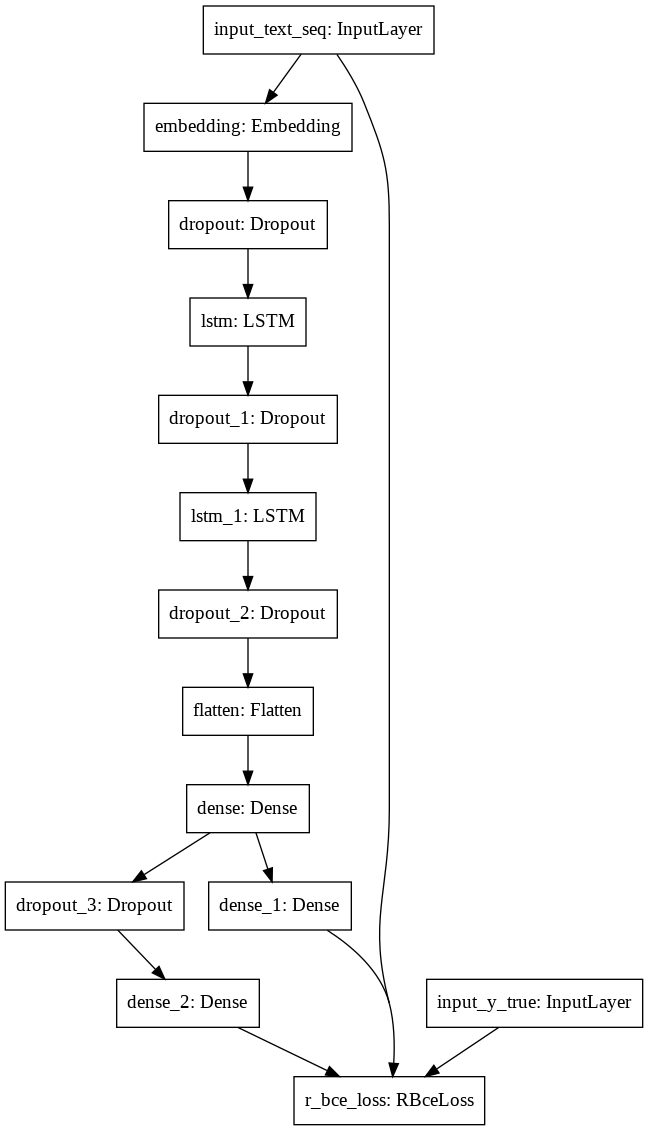

In [11]:
model, model_pred = lstm_model()
plot_model(model)

In [ ]:
np.random.seed(1)
set_seed(2)
model, model_pred = lstm_model()
model.summary()
res_cusLSTM = model.fit([X, Y], epochs=23, shuffle=True, validation_split=0.2, batch_size=64)

Model: "functional_627"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_seq (InputLayer)     [(None, 68)]         0                                            
__________________________________________________________________________________________________
embedding_173 (Embedding)       (None, 68, 100)      1476600     input_text_seq[0][0]             
__________________________________________________________________________________________________
dropout_540 (Dropout)           (None, 68, 100)      0           embedding_173[0][0]              
__________________________________________________________________________________________________
lstm_200 (LSTM)                 (None, 68, 32)       17024       dropout_540[0][0]                
_____________________________________________________________________________________

In [ ]:
# model.save('./models/CusLoss_g50-2lstm32-fc16-23epo-64b-0.2814_642.h5')
# model_pred.save('./models/CusLoss_g50-2lstm32-fc16-23epo-64b-0.2814_642_pre.h5')


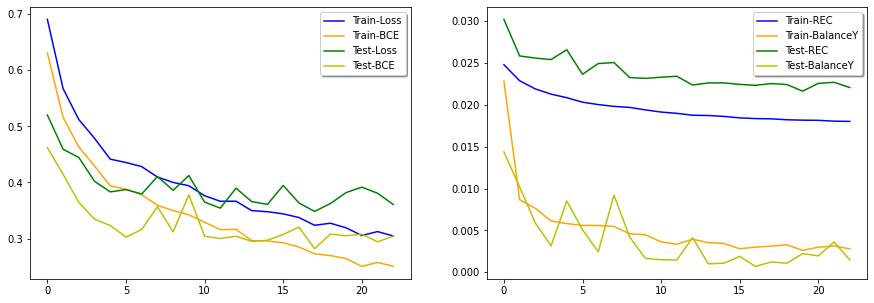

In [ ]:
def VisRes(res):
    plt.figure(figsize=(15,5))
    plt.subplot('121')
    plt.plot(list(res.history.values())[0],'b',label='Train-Loss')
    plt.plot(list(res.history.values())[1],'orange',label='Train-BCE')
    plt.plot(list(res.history.values())[4],'g',label='Test-Loss')
    plt.plot(list(res.history.values())[5],'y',label='Test-BCE')
    plt.legend(loc='best', shadow=True)
    plt.subplot('122')
    plt.plot(list(res.history.values())[2],'b',label='Train-REC')
    plt.plot(list(res.history.values())[3],'orange',label='Train-BalanceY')
    plt.plot(list(res.history.values())[6],'g',label='Test-REC')
    plt.plot(list(res.history.values())[7],'y',label='Test-BalanceY')
    plt.legend(loc='best', shadow=True)
    plt.show()
VisRes(res_cusLSTM)

In [ ]:
X.shape, Y.shape

((8000, 68), (8000, 2))

### LSTM-orig

Epoch 1/23
100/100 [==============================] - 1s 14ms/step - loss: 0.7389 - accuracy: 0.7233 - val_loss: 0.5662 - val_accuracy: 0.8206
Epoch 2/23
100/100 [==============================] - 1s 11ms/step - loss: 0.5874 - accuracy: 0.8045 - val_loss: 0.4947 - val_accuracy: 0.8419
Epoch 3/23
100/100 [==============================] - 1s 11ms/step - loss: 0.5181 - accuracy: 0.8261 - val_loss: 0.4607 - val_accuracy: 0.8487
Epoch 4/23
100/100 [==============================] - 1s 11ms/step - loss: 0.4729 - accuracy: 0.8328 - val_loss: 0.4131 - val_accuracy: 0.8650
Epoch 5/23
100/100 [==============================] - 1s 11ms/step - loss: 0.4366 - accuracy: 0.8523 - val_loss: 0.3990 - val_accuracy: 0.8706
Epoch 6/23
100/100 [==============================] - 1s 11ms/step - loss: 0.4116 - accuracy: 0.8583 - val_loss: 0.3835 - val_accuracy: 0.8763
Epoch 7/23
100/100 [==============================] - 1s 11ms/step - loss: 0.3843 - accuracy: 0.8675 - val_loss: 0.3723 - val_accuracy: 0.8825

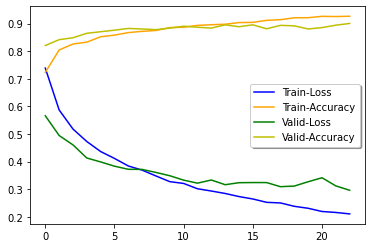

In [ ]:
# Glove + LSTM quick 
np.random.seed(1)
set_seed(2)
x = input_seq = Input(shape=(max_length, ))
x = Embedding(vocab_size, EMB_DIM, weights=[emb_matrix], trainable=True)(x)
x = Dropout(0.5)(x)
x = LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
# r = Dense(68, activation='relu')(x)

# r = Dense(max_length, activation='relu')(x)
x = Dropout(0.1)(x)
y = Dense(2, activation='sigmoid')(x)


Model_lstm = Model(input_seq, y)
Model_lstm.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
# Model_lstm.summary()
res_lstm_glove = Model_lstm.fit(X, Y, epochs=23, shuffle=True, validation_split=0.2, batch_size=64)
VisRes(res_lstm_glove) #2963 9044

Epoch 1/23
100/100 [==============================] - 2s 20ms/step - loss: 1.0105 - accuracy: 0.6187 - val_loss: 0.8897 - val_accuracy: 0.6056
Epoch 2/23
100/100 [==============================] - 1s 13ms/step - loss: 0.7881 - accuracy: 0.6439 - val_loss: 0.6589 - val_accuracy: 0.7088
Epoch 3/23
100/100 [==============================] - 1s 14ms/step - loss: 0.5918 - accuracy: 0.7561 - val_loss: 0.6097 - val_accuracy: 0.7494
Epoch 4/23
100/100 [==============================] - 1s 14ms/step - loss: 0.5200 - accuracy: 0.7881 - val_loss: 0.4779 - val_accuracy: 0.7825
Epoch 5/23
100/100 [==============================] - 1s 14ms/step - loss: 0.4830 - accuracy: 0.8094 - val_loss: 0.4320 - val_accuracy: 0.8325
Epoch 6/23
100/100 [==============================] - 1s 14ms/step - loss: 0.4640 - accuracy: 0.8134 - val_loss: 0.4290 - val_accuracy: 0.8138
Epoch 7/23
100/100 [==============================] - 1s 14ms/step - loss: 0.4293 - accuracy: 0.8322 - val_loss: 0.3922 - val_accuracy: 0.8400

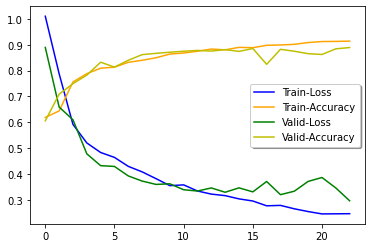

In [ ]:
# Glove + LSTM * 2 quick & best 
np.random.seed(1)
set_seed(2)
model = Sequential()
model.add(Embedding(vocab_size, EMB_DIM, input_length=max_length, weights=[emb_matrix], trainable=True))
model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=True, kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')) # defaultly use tanh for cuDNNLSTM
model.add(Dropout(0.2))
model.add(LSTM(32, kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform')) # defaultly use tanh for cuDNNLSTM
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(2, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001),kernel_initializer='he_uniform'))

# opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)
model.compile(loss = "binary_crossentropy", 
             optimizer = 'rmsprop',
             metrics = ['accuracy'])
results_lstm_glove = model.fit(X, Y, epochs=23, shuffle=True, validation_split=0.2, batch_size=64)
VisRes(results_lstm_glove)

In [ ]:
# Model_lstm.save('./models/lstm_g50-lstm32-fc16-23epo-68batch-0.3602_603.h5')

# DEV set

In [ ]:
dev = pd.read_csv("public_dev.csv")
dev.loc[:,'tokens'] = [processText(t, rmStop=True) for t in dev.text]
dev.loc[:,'token_len'] = [len(t) for t in dev.tokens]
dev

,id,text,tokens,token_len
0,8001,What's the difference between a Bernie Sanders...,"['s, difference, bernie, sanders, supporter, f...",13
1,8002,"Vodka, whisky, tequila. I'm calling the shots.","[vodka, whisky, tequila, 'm, calling, shots]",6
2,8003,French people don't masturbate They Jacque off,"[french, people, n't, masturbate, jacque]",5
3,8004,A lot of Suicide bombers are Muslims - I don't...,"[lot, suicide, bombers, muslims, -, n't, blame...",11
4,8005,What happens when you fingerbang a gypsy on he...,"[happens, fingerbang, gypsy, period, ?, get, p...",8
...,...,...,...,...
995,8996,boss: what are you doing inventor of the bagpi...,"[boss, :, inventor, bagpipes, :, no, fucking, ...",8
996,8997,I told him his views were pretty extreme and i...,"[told, views, pretty, extreme, would, benefici...",12
997,8998,"""Mum, all the black kids call each other Nigga...","[``, mum, black, kids, call, nigga, call, get,...",16
998,8999,"In honor of Fathers Day, I'm gonna bring you ""...","[honor, fathers, day, 'm, gon, na, bring, ``, ...",40


In [ ]:
X_dev, vocab_size_dev, max_length_dev = encodeText(dev['tokens'], max_len=max_length)
X_dev.shape, vocab_size_dev, max_length_dev

((1000, 68), 14766, 68)

In [ ]:
# task 1a
y_pred = model_pred.predict(X_dev)
y_pred = [np.argmax(i) for i in y_pred]
pd.Series(y_pred).value_counts() #lstm2 emb+fc16:/622/623 emb:646,  y_balance+abs609 square606 y_bala+squ+quanti(r-y_true)608 ...(r-y_true)601

1    668
0    332
dtype: int64

In [ ]:
output = pd.DataFrame(dev.loc[:,'id'])
output.loc[:,'is_humor'] = y_pred
compression_opts = dict(method='zip', archive_name='res.csv')  
output.to_csv('zehao_liu_dev37_lstm2_g100d0.7_fc16_617_rec_bal_quantiYTrue.zip', index=None, compression=compression_opts)